In [ ]:
!pip install -q kaggle

In [ ]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, make_scorer

In [ ]:
#Realiza o download do dataset direto do kaggle
!kaggle datasets download --force -d kamilpytlak/personal-key-indicators-of-heart-disease

Dataset URL: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
License(s): CC0-1.0
 79% 17.0M/21.4M [00:00<00:00, 84.7MB/s]
100% 21.4M/21.4M [00:00<00:00, 86.0MB/s]


In [ ]:
#Realiza a leitura do dataset
data = pd.read_csv(ZipFile("personal-key-indicators-of-heart-disease.zip").open('2022/heart_2022_no_nans.csv'), sep=',')
dataOriginal = data.copy()

In [ ]:
# Pré-processamento
data['HadHeartAttack'] = LabelEncoder().fit_transform(data['HadHeartAttack'])

categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

scaler = MinMaxScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

X = data_encoded.drop('HadHeartAttack', axis=1)
y = data_encoded['HadHeartAttack']

In [ ]:
y.value_counts()

,count
HadHeartAttack,
0.0,232587
1.0,13435


In [ ]:
# Balanceamento de classes usando SMOTE
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X, y)

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=200, max_depth=40, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, n_estimators=200, random_state=42)

In [ ]:
X_test_filled = X_test.fillna(X_test.mean())
y_pred_model = model.predict(X_test_filled)

In [ ]:
accuracy_logreg = accuracy_score(y_test, y_pred_model)
print(f"Accuracy: {accuracy_logreg}")

recall_logreg = recall_score(y_test, y_pred_model)
print(f"Recall: {recall_logreg}")

Accuracy: 0.9738915461922932
Recall: 0.9846071044133476


In [ ]:
print(classification_report(y_test, y_pred_model))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     46585
         1.0       0.96      0.98      0.97     46450

    accuracy                           0.97     93035
   macro avg       0.97      0.97      0.97     93035
weighted avg       0.97      0.97      0.97     93035



<ipython-input-40-73e70191c433>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top), palette='Set2')


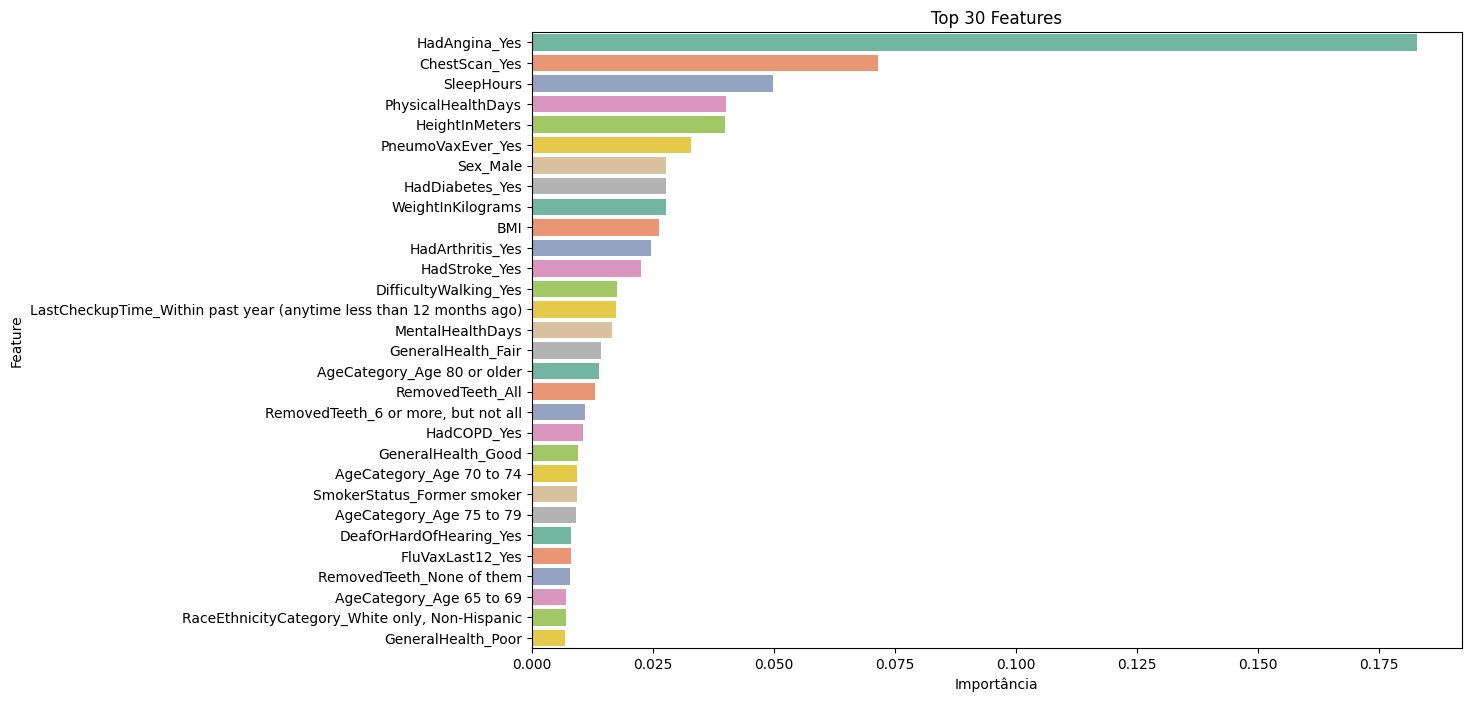

Total de Features: 121


In [ ]:
top = 30

# Calcula as importâncias das features
importances = model.feature_importances_

# Cria um dataframe para melhor visualização
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordena as features pela importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotando as importâncias das features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top), palette='Set2')
plt.title(f'Top {top} Features')
plt.xlabel('Importância')
plt.ylabel('Feature')

plt.show()

print(f"Total de Features: {len(X.columns)}")

## Criacao do bin do modelo treinado


In [ ]:
joblib.dump(model, 'random_forest_model.joblib')
print("Model saved as random_forest_model.joblib")

## Criacao do tar para Sagemaker

In [ ]:
with tarfile.open('model.tar.gz', 'w:gz') as tar:
    tar.add('random_forest_model.joblib')
    tar.add('model.py')
    tar.add('requirements.txt')

print("Model packaged as model.tar.gz")

## Envio para o S3

In [ ]:
# Set up S3 client
s3 = boto3.client('s3')

# Specify your S3 bucket and key
bucket_name = 'infnet-models-bucket'
s3_key = 'random_forest_model/model.tar.gz'

# Upload the model to S3
s3.upload_file('model.tar.gz', bucket_name, s3_key)

model_data = f's3://{bucket_name}/{s3_key}'

print(f"Model uploaded to s3://{bucket_name}/{s3_key}")

## Deploy the model on SageMaker

In [ ]:
# Set up SageMaker session
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# Create SKLearnModel
sklearn_model = SKLearnModel(model_data=model_data,
                             role=role,
                             entry_point='model.py',
                             framework_version='1.2-1',  # This is currently the latest version
                             py_version='py3')

predictor = sklearn_model.deploy(instance_type='ml.m5.large',
                                 initial_instance_count=1)
# Deploy the model
print(f"Model deployed. Endpoint name: {predictor.endpoint_name}")

## Teste do modelo

In [ ]:
sample_input = X_test.iloc[0:1].values.tolist()
print(f"input: {sample_input}")

sample_input = X_test.iloc[1:2].values.tolist()
print(f"input 2 : {sample_input}")

sample_input = X_test.iloc[2:3].values.tolist()
print(f"input 3: {sample_input}")

sample_input = X_test.iloc[3:4].values.tolist()
print(f"input 4: {sample_input}")

sample_input =  [[0.0, 0.0, 7.0, 1.7, 70.0, 24.221453287197235, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]]
print(f"stream lit input: {sample_input}")

In [ ]:
# Prepare a sample input
sample_input = X_test.iloc[0:1].values.tolist()
print(f"input: {sample_input}")

# Make a prediction
result = predictor.predict(sample_input)

print(f"Prediction: {result}")

## Teste usando o endpoint do Sagemaker


In [ ]:
import json
# Create a SageMaker runtime client
runtime_client = boto3.client('sagemaker-runtime')

# Prepare a sample input (ensure it's preprocessed the same way as during training)
sample_input = X_test.iloc[0:1].values.tolist()

# Convert the input to JSON format
input_json = json.dumps(sample_input)

# Make a prediction using the endpoint
response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType='application/json',
    Body=input_json
)

# Parse the response
result = json.loads(response['Body'].read().decode())

print(f"Prediction: {result}")
print(f"Actual label: {y_test.iloc[0]}")

## Clean Up

In [ ]:
#predictor.delete_endpoint()
print("Endpoint deleted")